***lib***

In [2]:
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel("ENB2012_data.xlsx")

In [4]:
df.nunique()

X1     12
X2     12
X3      7
X4      4
X5      2
X6      4
X7      4
X8      6
Y1    587
Y2    636
dtype: int64

In [5]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
thr_Y1 = df["Y1"].median()
thr_Y2 = df["Y2"].median()

y1_bin = (df["Y1"] >= thr_Y1).astype(int)
y2_bin = (df["Y2"] >= thr_Y2).astype(int)

print("Heating Load (Y1):")
print(y1_bin.value_counts())

print("\nCooling Load (Y2):")
print(y2_bin.value_counts())


Heating Load (Y1):
Y1
0    384
1    384
Name: count, dtype: int64

Cooling Load (Y2):
Y2
0    384
1    384
Name: count, dtype: int64


In [5]:
mapping = {
    "X1":"Relative Compactness", 
    "X2":"Surface Area", 
    "X3":"Wall Area", 
    "X4": "Roof Area", 
    "X5": "Overall Height", 
    "X6": "Orientation", 
    "X7": "Glazing Area", 
    "X8": "Glazing Area Distribution", 
    "Y1": "Heating Load", 
    "Y2":"Cooling Load", 
}


***plots***

In [6]:
def visualize(df, mapping):
    for j, col in enumerate(df.columns):
        if j < 8:  
            color = "skyblue"
        else:     
            color = "orange"

        fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 

        # Boxplot
        axes[0].boxplot(
            df[col],
            patch_artist=True,
            boxprops=dict(facecolor=color, color=color, linewidth=2),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color=color, linewidth=2),
            capprops=dict(color=color, linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='black', markersize=5, linestyle='none')
        )
        axes[0].set_title(f"{mapping[col]} - Boxplot", fontsize=12)
        axes[0].set_ylabel("Value")

        # Histogram
        axes[1].hist(df[col], bins=20, color=color, edgecolor='black', alpha=0.7)
        axes[1].set_title(f"{mapping[col]} - Histogram", fontsize=12)
        axes[1].set_xlabel("Value")
        axes[1].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()


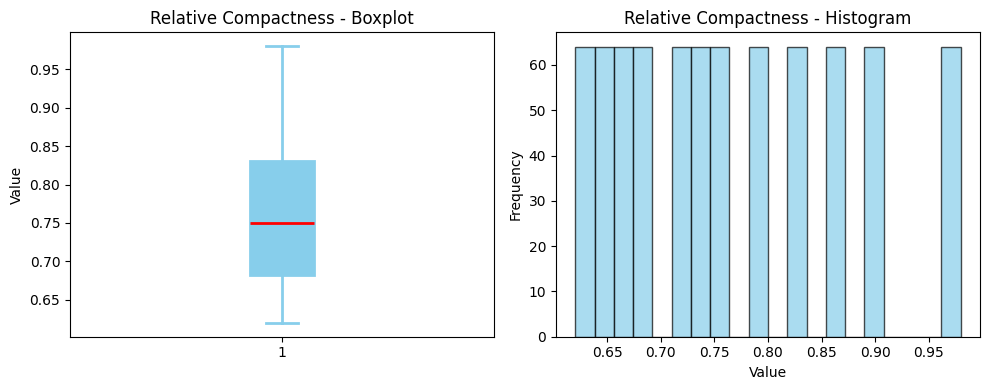

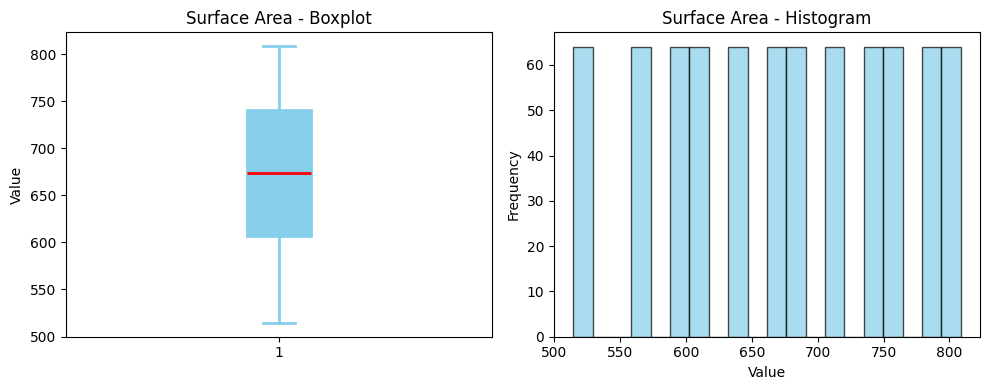

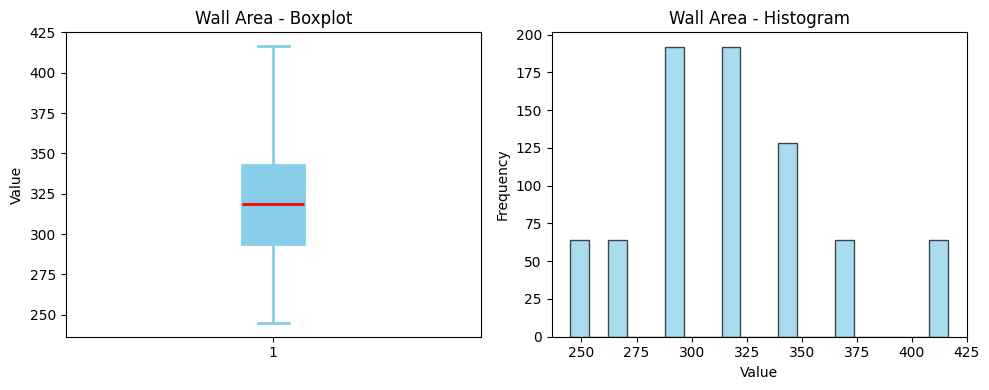

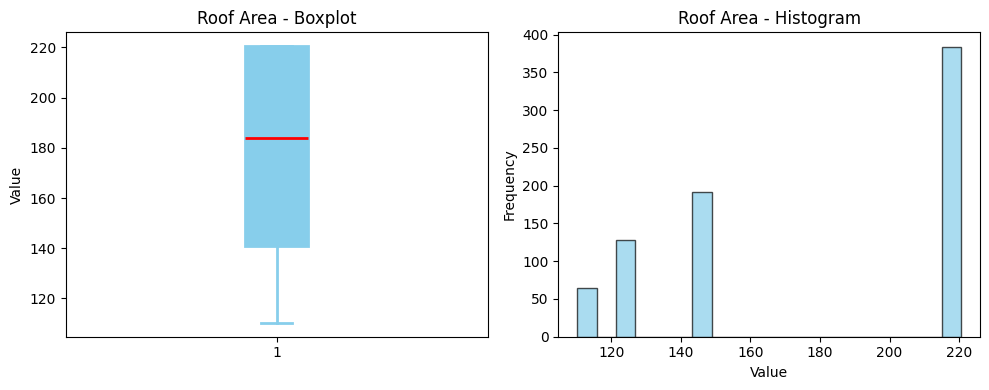

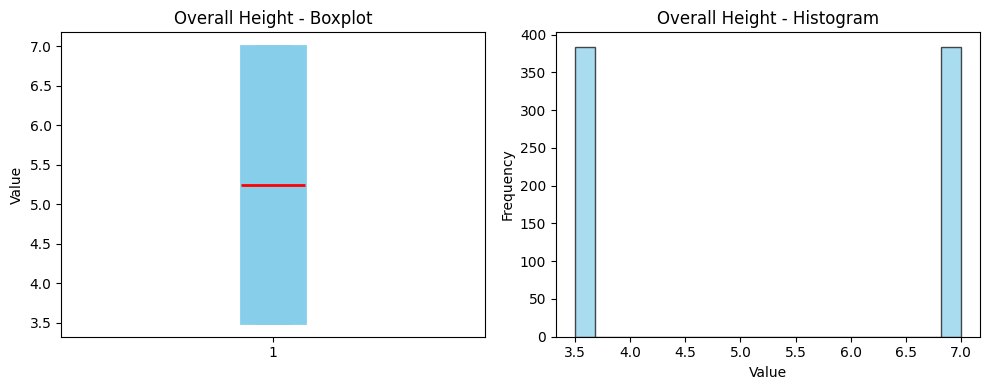

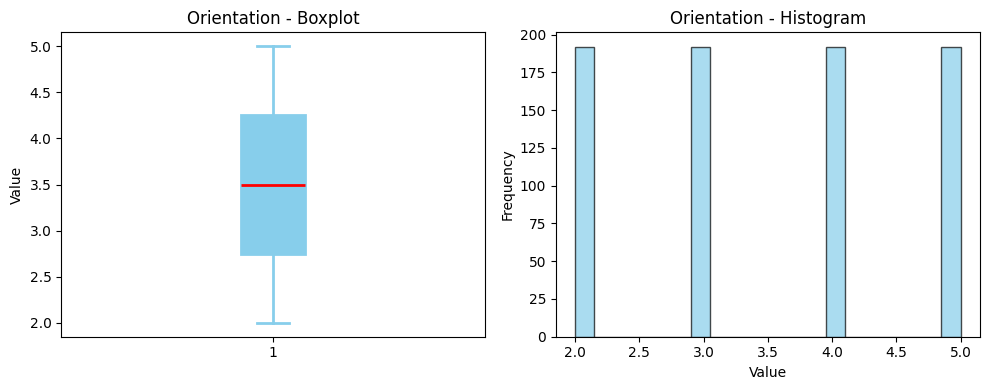

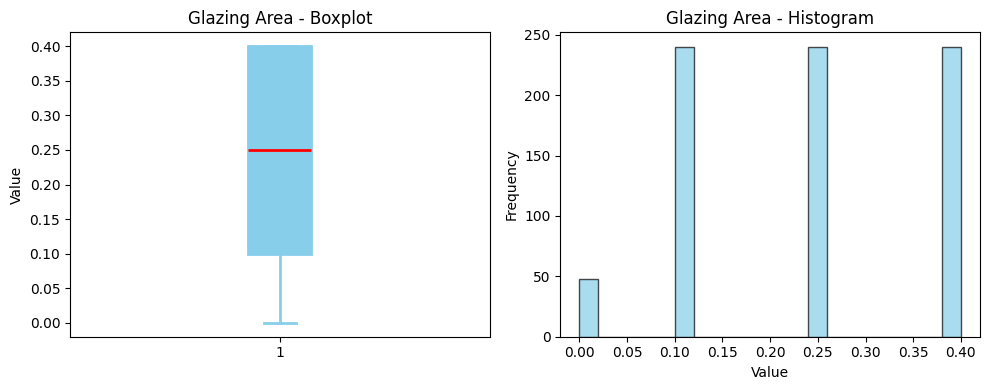

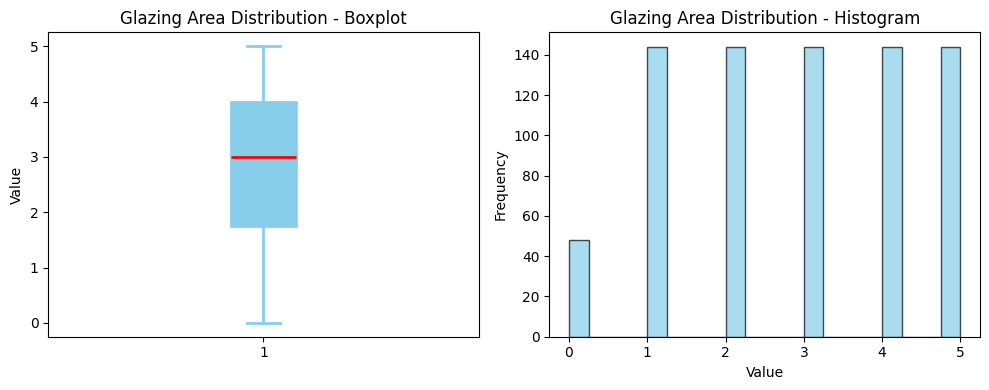

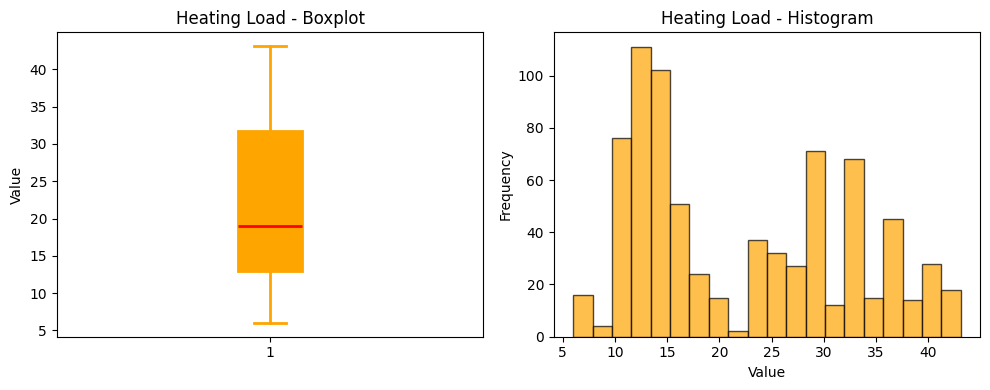

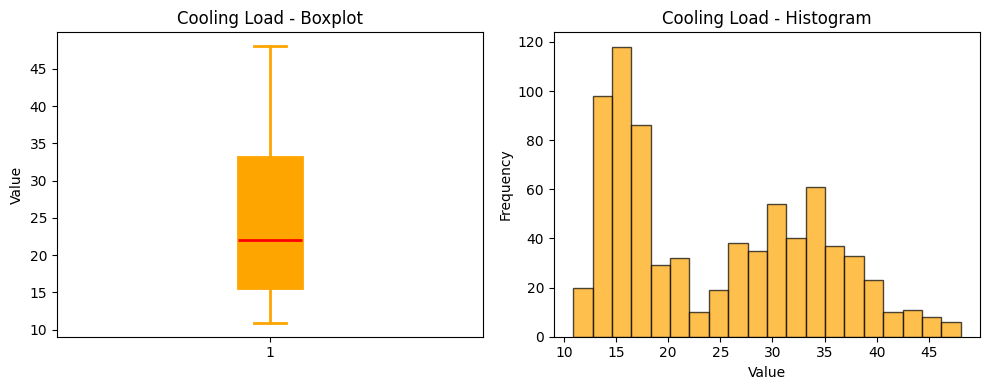

In [7]:
visualize(df,mapping)

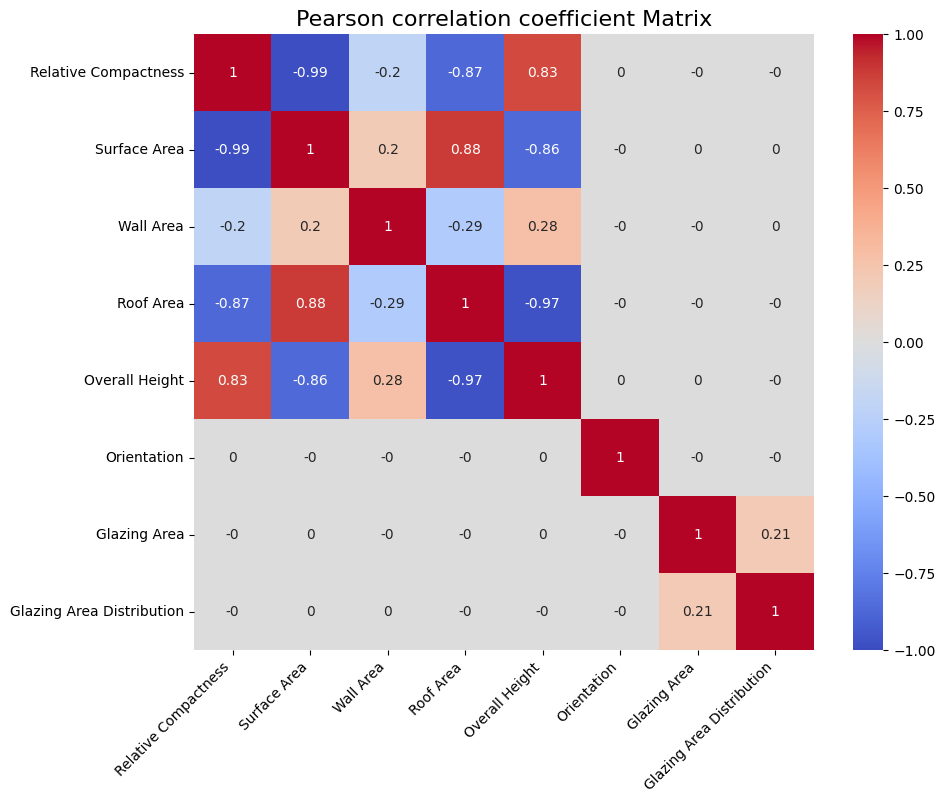

In [8]:
mapping = [
    "Relative Compactness", 
    "Surface Area", 
    "Wall Area", 
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution"
]

features_df = df.iloc[:, :8]
corr_matrix = features_df.corr(method='pearson').round(2)
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,vmax=1,
    xticklabels=mapping,
    yticklabels=mapping
)
plt.title("Pearson correlation coefficient Matrix",fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

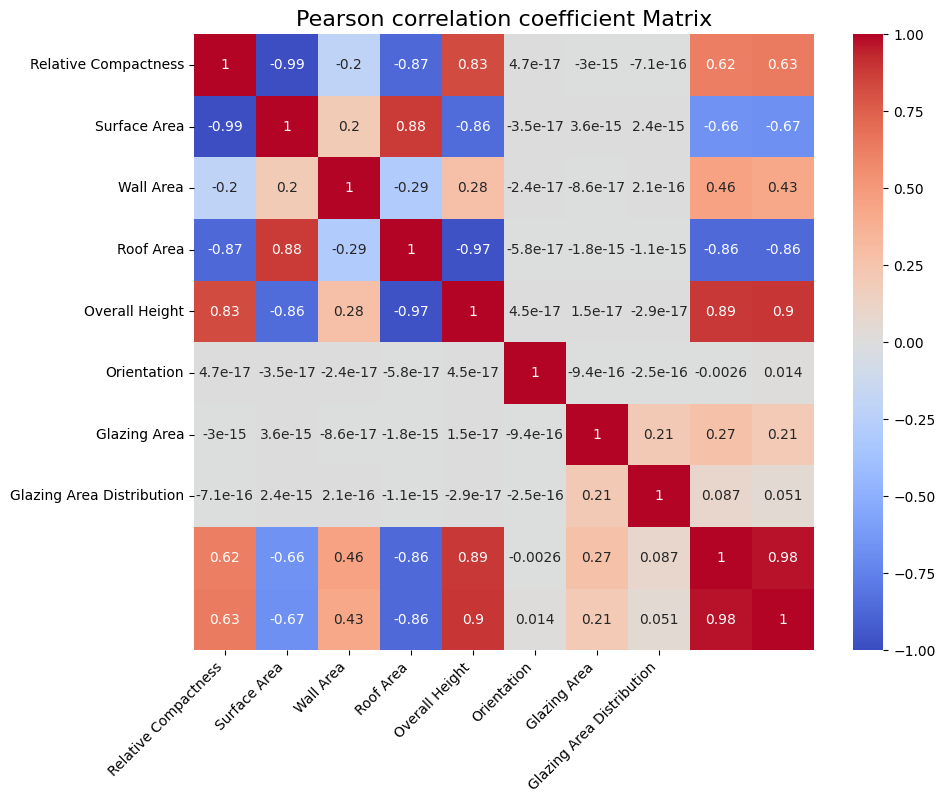

In [9]:
features_df = df.iloc[:, :]
corr_matrix = features_df.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,vmax=1,
    xticklabels=mapping,
    yticklabels=mapping
)
plt.title("Pearson correlation coefficient Matrix",fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [10]:
features = ["X1","X2","X3","X4","X5","X6","X7","X8"]
targets  = ["Y1","Y2"]  # Y1=Heating, Y2=Cooling

corr = df[features + targets].corr(method="pearson").loc[features, targets]

w = corr.abs()

w_norm = w / w.max(axis=0)

weights_table = w_norm.round(3)

print("Raw Pearson r:\n", corr.round(3), "\n")
print("Normalized weights (0..1):\n", weights_table)


Raw Pearson r:
        Y1     Y2
X1  0.622  0.634
X2 -0.658 -0.673
X3  0.456  0.427
X4 -0.862 -0.863
X5  0.889  0.896
X6 -0.003  0.014
X7  0.270  0.208
X8  0.087  0.051 

Normalized weights (0..1):
        Y1     Y2
X1  0.700  0.708
X2  0.740  0.751
X3  0.512  0.477
X4  0.969  0.963
X5  1.000  1.000
X6  0.003  0.016
X7  0.303  0.232
X8  0.098  0.056


In [10]:
# mapping = {
#     'Relative Compactness': 'X1',
#     'Surface Area': 'X2',
#     'Wall Area': 'X3',
#     'Roof Area': 'X4',
#     'Overall Height': 'X5',
#     'Orientation': 'X6',
#     'Glazing Area': 'X7',
#     'Glazing Area Distribution': 'X8',
#     'Heating Load': 'Y1',
#     'Cooling Load': 'Y2',
# }
# rename_map = {k:v for k,v in mapping.items() if k in df.columns}
# if rename_map:
#     df = df.rename(columns=rename_map)

# cols_needed = [f"X{i}" for i in range(1,9)] + ["Y1","Y2"]
# df = df[cols_needed].copy()
# for c in df.columns:
#     df[c] = pd.to_numeric(df[c], errors="coerce")
# df = df.dropna()

# features = [f"X{i}" for i in range(1,9)]

# def fit_ols_and_print(y_col, title, round_dec=3, drop_small=0.0):
#     X = sm.add_constant(df[features], has_constant="add")
#     y = df[y_col]
#     model = sm.OLS(y, X).fit()

#     coef = model.params.copy()
#     if drop_small > 0:
#         for k in coef.index:
#             if k != "const" and abs(coef[k]) < drop_small:
#                 coef[k] = 0.0

#     order = ["const"] + features
#     terms = []
#     for name in order:
#         if name in coef.index:
#             val = round(float(coef[name]), round_dec)
#             if name == "const":
#                 terms.append(f"{val}")
#             else:
#                 sign = "+" if val >= 0 else ""
#                 terms.append(f"{sign}{val}*{name}")
#     equation = " ".join(terms)

#     print(f"\n=== {title} ({y_col}) ===")
#     print("Equation:")
#     print(f"Y = {equation}")
#     print(f"R^2 = {model.rsquared:.4f}")

# fit_ols_and_print("Y2", "Heating Load ", round_dec=3, drop_small=0.0)
# fit_ols_and_print("Y1", "Cooling Load ", round_dec=3, drop_small=0.0)

# # fit_ols_and_print("Y2", "Heating Load (clean)", round_dec=3, drop_small=0.01)
# # fit_ols_and_print("Y1", "Cooling Load (clean)", round_dec=3, drop_small=0.01)


Regression

In [11]:
mapping = {
    'Relative Compactness': 'X1',
    'Surface Area': 'X2',
    'Wall Area': 'X3',
    'Roof Area': 'X4',
    'Overall Height': 'X5',
    'Orientation': 'X6',
    'Glazing Area': 'X7',
    'Glazing Area Distribution': 'X8',
    'Heating Load': 'Y1',
    'Cooling Load': 'Y2',
}
rename_map = {k:v for k,v in mapping.items() if k in df.columns}
if rename_map:
    df = df.rename(columns=rename_map)

cols_needed = [f"X{i}" for i in range(1,9)] + ["Y1","Y2"]
df = df[cols_needed].copy()
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna()

features = [f"X{i}" for i in range(1,9)]

def fit_ols_and_print(y_col, title, round_dec=3, drop_small=0.0):
    X = sm.add_constant(df[features], has_constant="add")
    y = df[y_col]
    model = sm.OLS(y, X).fit()

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    coef = model.params.copy()
    if drop_small > 0:
        for k in coef.index:
            if k != "const" and abs(coef[k]) < drop_small:
                coef[k] = 0.0

    order = ["const"] + features
    terms = []
    for name in order:
        if name in coef.index:
            val = round(float(coef[name]), round_dec)
            if name == "const":
                terms.append(f"{val}")
            else:
                sign = "+" if val >= 0 else ""
                terms.append(f"{sign}{val}*{name}")
    equation = " ".join(terms)

    print(f"\n=== {title} ({y_col}) ===")
    print(f"Equation:\nY = {equation}")
    print(f"R²   = {r2:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAE  = {mae:.4f}")

fit_ols_and_print("Y2", "Heating Load (paper style)", round_dec=3, drop_small=0.0)
fit_ols_and_print("Y1", "Cooling Load (paper style)", round_dec=3, drop_small=0.0)



=== Heating Load (paper style) (Y2) ===
Equation:
Y = 97.246 -70.788*X1 -0.066*X2 +0.023*X3 -0.044*X4 +4.284*X5 +0.122*X6 +14.717*X7 +0.041*X8
R²   = 0.8878
RMSE = 3.1845
MAE  = 2.2424

=== Cooling Load (paper style) (Y1) ===
Equation:
Y = 84.013 -64.773*X1 -0.063*X2 +0.036*X3 -0.049*X4 +4.17*X5 -0.023*X6 +19.933*X7 +0.204*X8
R²   = 0.9162
RMSE = 2.9190
MAE  = 2.0669


In [13]:
df["Y1"].min()

6.01

In [14]:
df["Y1"].max()

43.1

In [25]:
X = df[['X1','X2','X3', 'X4', 'X6', 'X7', 'X8']]  

y1_threshold = np.percentile(df['Y1'], 95)
y1_binary = (df['Y1'] > y1_threshold).astype(int)

y2_threshold = np.percentile(df['Y2'], 95)
y2_binary = (df['Y2'] > y2_threshold).astype(int)
l = {}
scaler = StandardScaler()
X = scaler.fit_transform(X)

def evaluate_models(X, y, label,name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    lr = LogisticRegression(max_iter=1000, class_weight=None)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    lr_acc = accuracy_score(y_test, y_pred_lr)
    lr_f1 = f1_score(y_test, y_pred_lr)
    N = name + "_regression"
    l[N] = lr_acc

    dt = DecisionTreeClassifier(max_depth=10, random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    dt_acc = accuracy_score(y_test, y_pred_dt)
    dt_f1 = f1_score(y_test, y_pred_dt)
    N = name + "_DT"
    l[N] = dt_acc

    print(f'{label} - Logistic Regression Accuracy: {lr_acc:.4f}, F1-Score: {lr_f1:.4f}')
    # print(f'{label} - Decision Tree Accuracy: {dt_acc:.4f}, F1-Score: {dt_f1:.4f}')
    print(f'{label} - Better model (by Accuracy): {"Decision Tree" if dt_acc > lr_acc else "Logistic Regression"}')
    print(f'{label} - Accuracy difference (DT - LR): {dt_acc - lr_acc:.4f}')
    # print(f'{label} - F1-Score difference (DT - LR): {dt_f1 - lr_f1:.4f}\n')

evaluate_models(X, y1_binary, 'Y1 Binary','heating')

evaluate_models(X, y2_binary, 'Y2 Binary','cooling')

Y1 Binary - Logistic Regression Accuracy: 0.9675, F1-Score: 0.6154
Y1 Binary - Better model (by Accuracy): Decision Tree
Y1 Binary - Accuracy difference (DT - LR): 0.0195
Y2 Binary - Logistic Regression Accuracy: 0.9416, F1-Score: 0.0000
Y2 Binary - Better model (by Accuracy): Decision Tree
Y2 Binary - Accuracy difference (DT - LR): 0.0260


In [26]:
l

{'heating_regression': 0.9675324675324676,
 'heating_DT': 0.987012987012987,
 'cooling_regression': 0.9415584415584416,
 'cooling_DT': 0.9675324675324676}

In [ ]:
X = df[['X1', 'X2', 'X3', 'X4', 'X6', 'X7', 'X8']]
y1_threshold = np.percentile(df['Y1'], 95)
y1_binary = (df['Y1'] > y1_threshold).astype(int)

y2_threshold = np.percentile(df['Y2'], 95)
y2_binary = (df['Y2'] > y2_threshold).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train_Y1, y_test_Y1 = train_test_split(
    X_scaled, y1_binary, test_size=0.2, random_state=42
)
_, _, y_train_Y2, y_test_Y2 = train_test_split(
    X_scaled, y2_binary, test_size=0.2, random_state=42
)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_Y1_tensor = torch.tensor(y_train_Y1.values, dtype=torch.float32).view(-1, 1)
y_test_Y1_tensor = torch.tensor(y_test_Y1.values, dtype=torch.float32).view(-1, 1)
y_train_Y2_tensor = torch.tensor(y_train_Y2.values, dtype=torch.float32).view(-1, 1)
y_test_Y2_tensor = torch.tensor(y_test_Y2.values, dtype=torch.float32).view(-1, 1)

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x


def evaluate_nn(X_train, X_test, y_train, y_test, label,name):

    model = BinaryClassifier(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)


    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test)
        y_pred = (y_pred_tensor.round()).numpy()
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    l[name] = acc
    print(f'--- Neural Network for {label} ---')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-Score: {f1:.4f}\n')
    

evaluate_nn(X_train_tensor, X_test_tensor, y_train_Y1_tensor, y_test_Y1_tensor, 'Y1 Binary','heating_NN')
evaluate_nn(X_train_tensor, X_test_tensor, y_train_Y2_tensor, y_test_Y2_tensor, 'Y2 Binary',"cooling_NN")


--- Neural Network for Y1 Binary ---
Accuracy: 0.9740
F1-Score: 0.7143

--- Neural Network for Y2 Binary ---
Accuracy: 0.9416
F1-Score: 0.0000



In [30]:
l

{'heating_regression': 0.9675324675324676,
 'heating_DT': 0.987012987012987,
 'cooling_regression': 0.9415584415584416,
 'cooling_DT': 0.9675324675324676,
 'heating_NN': 0.974025974025974,
 'cooling_NN': 0.9415584415584416}

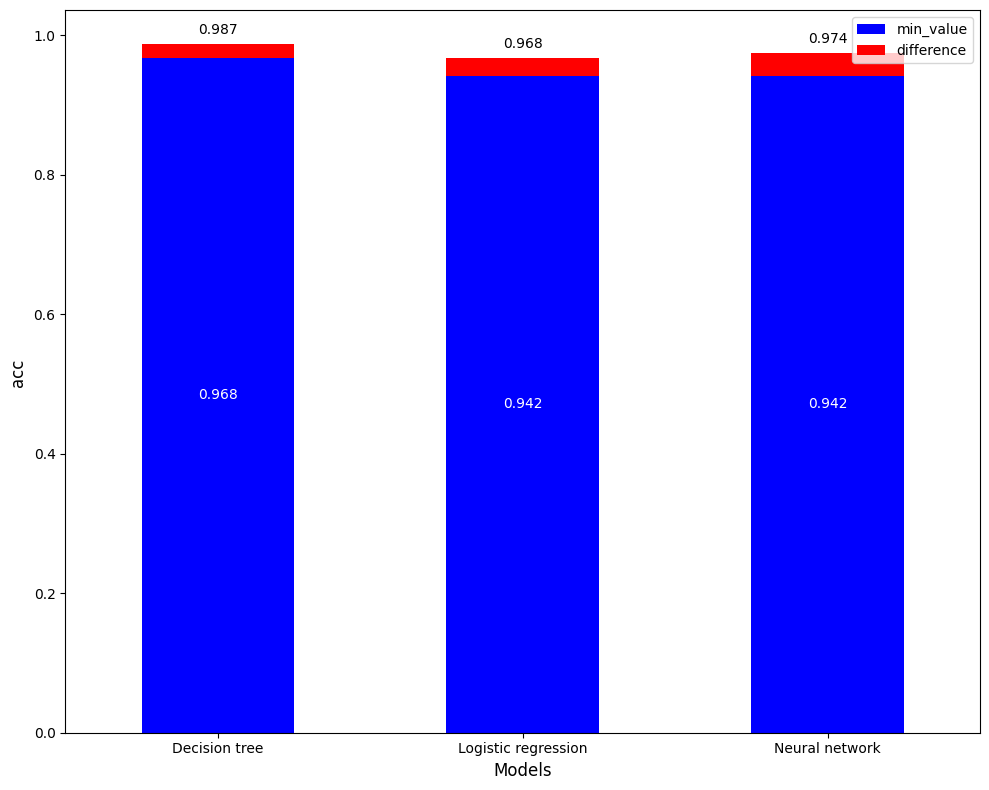

In [50]:

data_dict = l

plot_data = {
    'Decision tree': {'Heating load': data_dict['heating_DT'], 'Cooling load': data_dict['cooling_DT']},
    'Logistic regression': {'Heating load': data_dict['heating_regression'], 'Cooling load': data_dict['cooling_regression']},
    'Neural network': {'Heating load': data_dict['heating_NN'], 'Cooling load': data_dict['cooling_NN']}
}

df = pd.DataFrame(plot_data).T

# Calculate min value and the difference for each model
df['min_value'] = df.min(axis=1)
df['difference'] = df.max(axis=1) - df.min(axis=1)

# Create the stacked bar plot with min and difference
fig, ax = plt.subplots(figsize=(10, 8))
df[['min_value', 'difference']].plot(kind='bar', stacked=True, color=['blue', 'red'], ax=ax, rot=0)

# Add labels and a title
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('acc ', fontsize=12)
# ax.set_title('Comparison of R-squared Ranges for Heating and Cooling Loads', fontsize=14)

# Add a custom legend
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, ['Minimum R-squared', 'Difference to Maximum'], title='Metrics', loc='upper right')

# Add value labels to the bars
for i, model in enumerate(df.index):
    min_val = df.loc[model, 'min_value']
    diff_val = df.loc[model, 'difference']
    max_val = min_val + diff_val

    # Label for the min value (bottom part of the bar)
    ax.text(i, min_val / 2, f'{min_val:.3f}', ha='center', va='center', fontsize=10, color='white')

    # Label for the total value (at the top of the stacked bar)
    ax.text(i, max_val + 0.01, f'{max_val:.3f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show() # Use plt.show() to display the plots